# Building a Spam Filter with Naive Bayes

In this project, we're going to study the practical side of the algorithm by building a spam filter for SMS messages.

To classify messages as spam or non-spam we follow the below steps:
- Learns how humans classify messages.
- Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
- Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

**Our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).**

In [1]:
import pandas as pd

# header set to None to avoid using first row as header row. Data doesn't have header.
data=pd.read_csv("SMSSpamCollection",sep='\t',header=None,names=['Label', 'SMS'])

## Explore dataset

"ham" means non-spam message. Let's expore the data and find the percentage of spam and ham messages are in our data.


In [2]:
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data["Label"].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

About 87% are ham and 13% are spam messages

## Training and Test Set

It's very helpful to first think of a way of testing how well it works. When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

- **A training set:**, which we'll use to "train" the computer how to classify messages.We're going to keep 80% of our dataset for training.The training set will have 4,458 messages (about 80% of the dataset).
- **A test set:**, which we'll use to test how good the spam filter is with classifying new messages.20% for testing.The test set will have 1,114 messages.


**Process of testing our spam filter:**

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, *we're going to treat these messages as new and have the filter classify them*. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.


In [4]:
# Randomizing the entire dataset and set a seed to reproduce the results

data_randomized=data.sample(frac=1,random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

training_set=data_randomized[:training_test_index].reset_index()

test_set=data_randomized[training_test_index:].reset_index()

We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [5]:
training_set["Label"].value_counts(normalize=True)*100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [6]:
test_set["Label"].value_counts(normalize=True)*100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

**REMARK:** The percentage of spam and ham in both the training and the test set are similar to what we have in the full dataset.So, our sets looks good.

## Data Cleaning

To calculate all these probabilities, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. Right now, our training and test sets have this format (the messages are fictitious to make the example easier to understand):

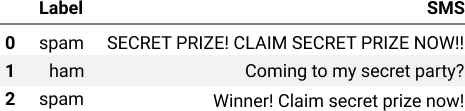

To make the calculations easier, we want bring the data to this format (the table below is a transformation of the table you see above):

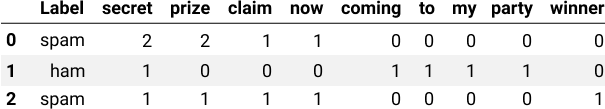

Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks). and bringing every letter to lower case.

In [7]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,index,Label,SMS
0,1078,ham,yep by the pretty sculpture
1,4028,ham,yes princess are you going to make me moan
2,958,ham,welp apparently he retired
3,4642,ham,havent
4,4674,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating training set

In [8]:
training_set["SMS"]=training_set["SMS"].str.split(" ")
training_set["SMS"].head()

0                  [yep, , by, the, pretty, sculpture]
1    [yes, , princess, , are, you, going, to, make,...
2                      [welp, apparently, he, retired]
3                                           [havent, ]
4    [i, forgot, 2, ask, ü, all, smth, , , there, s...
Name: SMS, dtype: object

In [9]:
# Creating list of unique words in spam and ham 

vocabulary=[]

for s in training_set["SMS"]:
    for word in s:
        if word not in vocabulary:
            vocabulary.append(word)

len(vocabulary)


7784

To create the dictionary we need for our training set and each value is a list of the length of training set, where each element in the list is a 0. We will used nested loop to populate the dictionary using sms (where sms is a list of strings, where each string represents a word in a message) by incrementing 1 for each word coressponding to index

In [10]:

word_counts_per_sms={word: [0] * len(training_set['SMS']) for word in vocabulary}


for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1
                                     

We have the dictionary we need, let's do the final transformations to our training set and then move forward with creating the spam filter. Also, add Label and the SMS columns to the new dataframe

In [11]:
word_counts=pd.DataFrame(word_counts_per_sms)
word_counts.head()

,yep,,by,the,pretty,sculpture,yes,princess,are,you,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
training_set_transformed=pd.concat([training_set,word_counts],axis=1)
training_set_transformed.head()

,index,Label,SMS,yep,,by,the,pretty,sculpture,yes,...,beauty,hides,secrets,n8,jewelry,related,trade,arul,bx526,wherre
0,1078,ham,"[yep, , by, the, pretty, sculpture]",1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4028,ham,"[yes, , princess, , are, you, going, to, make,...",0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,958,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4642,ham,"[havent, ]",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4674,ham,"[i, forgot, 2, ask, ü, all, smth, , , there, s...",0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating Spam filter using Naive Bayes algorithm

We're done with data cleaning and have a training set to work with, we can begin creating the spam filter. Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, recall that we need to use these equations: 
 










Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

- P(Spam) and P(Ham)
    
- NSpam, NHam, NVocabulary
    - NSpam and NHam is equal to the number of words (including repeated words) in all the spam and ham messages respectively.


We'll also use Laplace smoothing and set $\alpha = 1$.

In [13]:
# Isolating spam and ham messages first
spam_messages = training_set_transformed[training_set_transformed['Label'] == 'spam']
ham_messages = training_set_transformed[training_set_transformed['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_transformed)
p_ham = len(ham_messages) / len(training_set_transformed)

In [14]:
n_spam=spam_messages["SMS"].apply(len).sum()
n_ham=ham_messages["SMS"].apply(len).sum()

print(n_spam)

17956


In [15]:
alpha=1

n_vocabulary=len(vocabulary)

## Calculating parameters

- P(Spam) and P(Ham)
- NSpam, NHam, NVocabulary
All these terms will have constant values in our equations for every new message (regardless of the message or each individual word in the message).

However, P(wi|Spam) and P(wi|Ham) will vary depending on the individual words. For instance, P("secret"|Spam) will have a certain probability value, while P("cousin"|Spam) or P("lovely"|Spam) will most likely have other values.

We have 7,783 words in our vocabulary, which means we'll need to calculate a total of 15,566 probabilities. For each word, we need to calculate both P(wi|Spam) and P(wi|Ham). the probability values that P(wi|Spam) and P(wi|Ham) will take are called **parameters**.

The fact that we calculate so many values before even beginning the classification of new messages makes the Naive Bayes algorithm very fast.

**Note:** Nwi|Spam is equal to the number of times the word wi occurs in all the spam messages, while Nwi|Ham is equal to the number of times the word wi occurs in all the ham messages.

In [16]:
parameters_spam={}
parameters_ham={}

for word in vocabulary:
    parameters_spam[word]=0
    parameters_ham[word]=0

In [17]:
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Classify the message

For the classify() function above, note that:
 
- The input variable message is assumed to be a string.
- We perform a bit of data cleaning on the string message:
- We remove the punctuation using the re.sub() function.
- We bring all letters to lower case using the str.lower() method.
- We split the string at the space character and transform it into a Python list using the str.split() method.
- We calculate p_spam_given_message and p_ham_given_message — we'll write this code in the exercise below.
- We compare p_spam_given_message with p_ham_given_message and then print a classification label.

In [21]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
   
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
      
    for word in message:
        if word in parameters_spam:
            p_spam_given_message*=parameters_spam[word]
        elif word in parameters_ham:
            p_ham_given_message*=parameters_ham[word]
    
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [22]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 4.8441099043219405e-26
P(Ham|message): 0.8654104979811574
Label: Ham


In [23]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 1.099416001503406e-25
P(Ham|message): 0.8654104979811574
Label: Ham


In [24]:
test_set['predicted'] = test_set['SMS'].apply(classify)
test_set.head()

P(Spam|message): 1.5711983625881094e-26
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.1188825571729363e-34
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.789519784213709e-84
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.2966843068490754e-34
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.8430434787348154e-69
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 7.891673232489419e-112
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.281623618423652e-08
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.4083750639054047e-45
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.949846433375966e-43
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.83194610198441e-16
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 4.2495236076014543e-16
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.0460211098292484e-42
P(Ham|message): 0.8

P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 4.3582780653955633e-73
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.538383390924808e-102
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 7.057392191182059e-35
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.2830422067823362e-70
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.3857118672711177e-35
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 8.027632763545077e-105
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.294024603157728e-25
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.238944957319551e-39
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 9.165885908360697e-32
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 7.3350329365534315e-22
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.2274160870539506e-74
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|messa

P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.4067429491091404e-18
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.34671819315664e-53
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.3996484083163854e-26
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.6057155451780796e-43
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 4.469036531280074e-48
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.5776981232613255e-61
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.7478863181243078e-78
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.7240021920128634e-33
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.6245645296174868e-36
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.1343163224883708e-103
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.3642020853180733e-71
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|mes

P(Spam|message): 4.790369173701901e-108
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.8296149028513106e-19
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 4.5917860485747015e-79
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 4.108955437410008e-10
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 6.374453241573946e-23
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.7956050173666209e-40
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.4527918423887787e-72
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.285186785159069e-35
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 6.790545136458073e-83
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 1.0412692339937862e-66
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.2975227010240787e-70
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.0677557990583908e-66
P(Ham|message): 0.

P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.1040950074467482e-64
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.2075447312215343e-17
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.292388432463159e-34
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.500989464697658e-35
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.2605148285329032e-111
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.189511450385235e-74
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.642430820623822e-36
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 5.164785999730114e-62
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 3.378550246742477e-22
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 2.6322810303542348e-86
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message): 7.483246380420528e-63
P(Ham|message): 0.8654104979811574
Label: Ham
P(Spam|message

,index,Label,SMS,predicted
0,2131,ham,Later i guess. I needa do mcat study too.,None
1,3418,ham,But i haf enuff space got like 4 mb...,None
2,3424,spam,Had your mobile 10 mths? Update to latest Oran...,None
3,1538,ham,All sounds good. Fingers . Makes it difficult ...,None
4,5393,ham,"All done, all handed in. Don't know if mega sh...",None


## Finding the accuracy of the filter

The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label (given by a human). Note that, in training, our algorithm didn't see these 1,114 messages, so every message in the test set is practically new from the perspective of the algorithm.

First off, we'll change the classify() function that we wrote previously to return the labels instead of printing them. Below, note that we now have return statements instead of print() functions:

Finally, we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages.

     Accuracy=(number of correctly classified messages)/total number of classified messages


In [26]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
 
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [27]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,index,Label,SMS,predicted
0,2131,ham,Later i guess. I needa do mcat study too.,ham
1,3418,ham,But i haf enuff space got like 4 mb...,ham
2,3424,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,1538,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,5393,ham,"All done, all handed in. Don't know if mega sh...",ham


In [31]:
correct=0
total=test_set.shape[0]
for row in test_set.iterrows():
    row=row[1]
    if row["Label"]==row["predicted"]:
        correct+=1
accuracy=correct/total

In [32]:
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1099
Incorrect: 15
Accuracy: 0.9865350089766607


# Conclusion 

The accuracy is close to 98.65%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.65% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.

Next steps include:

- Analyze the 15 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly
- Make the filtering process more complex by making the algorithm sensitive to letter case